References

1. https://cs231n.github.io/neural-networks-2/#reg
2. https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Bayesian_Neural_Networks/dl2_bnn_tut2_student_with_answers.html

## Imports

In [1]:
### Regular Dropout

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd

import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [2]:
from tueplots import bundles
plt.rcParams.update(bundles.beamer_moml())


# Also add despine to the bundle using rcParams
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Increase font size to match Beamer template
plt.rcParams['font.size'] = 16
# Make background transparent
plt.rcParams['figure.facecolor'] = 'none'

Inspired from: https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Bayesian_Neural_Networks/dl2_bnn_tut2_student_with_answers.html

In [3]:
def get_simple_data_train():
    x = torch.linspace(-2, 4, 300)
    x = torch.hstack([x, torch.linspace(6, 8, 300)])
    f = lambda x: torch.sin(x)
    eps = torch.randn_like(x) * 0.1
    f_x = f(x) 
    y_train = f_x + eps
    x_train = x[:, None]
    return x_train, y_train, f

In [4]:
def plot_generic(add_to_plot=None):
    fig, ax = plt.subplots()

    plt.xlabel("X",)
    plt.ylabel("Y",)

    x_train, y_train, true_func = get_simple_data_train()
    
    x_all = torch.linspace(-2, 8, 1000)

    ax.plot(x_train, y_train, 'C0', marker='o', ms= 4, linestyle='none', alpha=0.2, label='Observations')
    ax.plot(x_all, true_func(x_all), 'C1', linewidth=1, label="true function")
    if add_to_plot is not None:
        add_to_plot(ax)

    plt.legend(loc=4, frameon=False)
    plt.show()

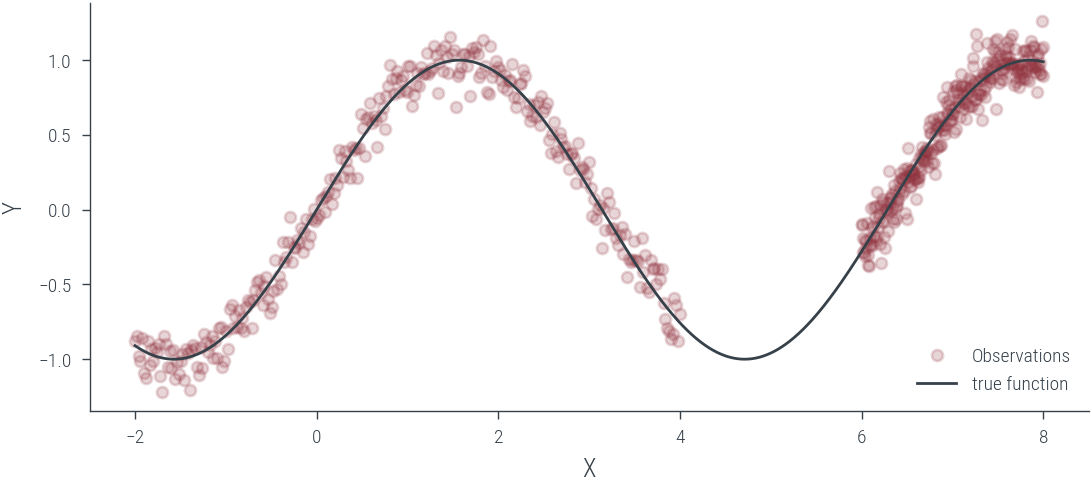

In [5]:
plot_generic()

In [6]:
# Define a simple MLP without using nn.Linear

input_dim = 1

hidden_l1_dim = 100
hidden_l2_dim = 50


def init_params():
    W1 = nn.Parameter(torch.randn(input_dim, hidden_l1_dim, requires_grad=True).to(device))
    b1 = nn.Parameter(torch.zeros(hidden_l1_dim, requires_grad=True).to(device))
    W2 = nn.Parameter(torch.randn(hidden_l1_dim, hidden_l2_dim, requires_grad=True).to(device))
    b2 = nn.Parameter(torch.zeros(hidden_l2_dim, requires_grad=True).to(device))
    W3 = nn.Parameter(torch.randn(hidden_l2_dim, 1, requires_grad=True).to(device))
    b3 = nn.Parameter(torch.zeros(1, requires_grad=True).to(device))
    return [W1, b1, W2, b2, W3, b3]


def mlp(x, params, p=0.0):
    W1, b1, W2, b2, W3, b3 = params
    h1 = torch.tanh(x @ W1 + b1)
    h2 = torch.tanh(h1 @ W2 + b2)
    return (h2 @ W3 + b3).ravel()

In [7]:
train_x, train_y, true_func = get_simple_data_train()
train_x = train_x.to(device)
train_y = train_y.to(device)


In [8]:
train_x.shape

torch.Size([600, 1])

In [9]:
test_x = torch.linspace(-2, 8, 1000)[:, None]
test_x = test_x.to(device)

In [10]:
parameters = init_params()


with torch.no_grad():
    y_hat_untrained = mlp(test_x, parameters).ravel()
# Detach and convert to numpy
y_hat_untrained = y_hat_untrained.cpu().detach().numpy()

In [11]:
def plot_predictions(x_test, y_preds):
    def add_predictions(ax):
        ax.plot(x_test, y_preds, 'C2', label='neural net prediction')

    plot_generic(add_predictions)


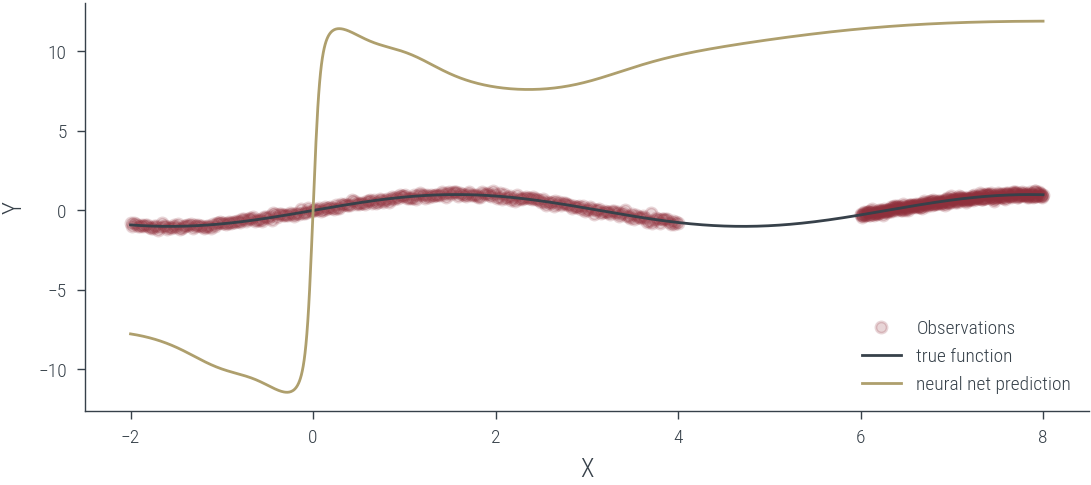

In [12]:
# Plot the untrained model
plot_predictions(test_x.cpu(), y_hat_untrained)

## Simple MLP

In [13]:
# Modify the train function to pass the dropout flag and dropout probability
def train(params, opt, fwd_func, x_train, y_train, epochs=1000, dropout=False, p=0.0):
    for i in range(epochs):
        y_hat = fwd_func(x_train, params, p)  # Pass the dropout flag and probability to fwd_func
        loss = F.mse_loss(y_hat, y_train)
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        if i % 300 == 0:
            print(f"Epoch {i}, loss {loss.item():.3f}")
    return params

In [14]:
parameters = init_params()

# Continue with optimizer
optimizer = torch.optim.Adam(parameters, lr=3e-4)

trained_params = train(parameters, optimizer, mlp, train_x, train_y, epochs=6000, dropout=False, p=0.0)

Epoch 0, loss 23.237
Epoch 300, loss 0.044
Epoch 600, loss 0.023
Epoch 900, loss 0.016
Epoch 1200, loss 0.014
Epoch 1500, loss 0.013
Epoch 1800, loss 0.012
Epoch 2100, loss 0.011
Epoch 2400, loss 0.011
Epoch 2700, loss 0.011
Epoch 3000, loss 0.010
Epoch 3300, loss 0.010
Epoch 3600, loss 0.010
Epoch 3900, loss 0.010
Epoch 4200, loss 0.010
Epoch 4500, loss 0.010
Epoch 4800, loss 0.009
Epoch 5100, loss 0.009
Epoch 5400, loss 0.009
Epoch 5700, loss 0.009


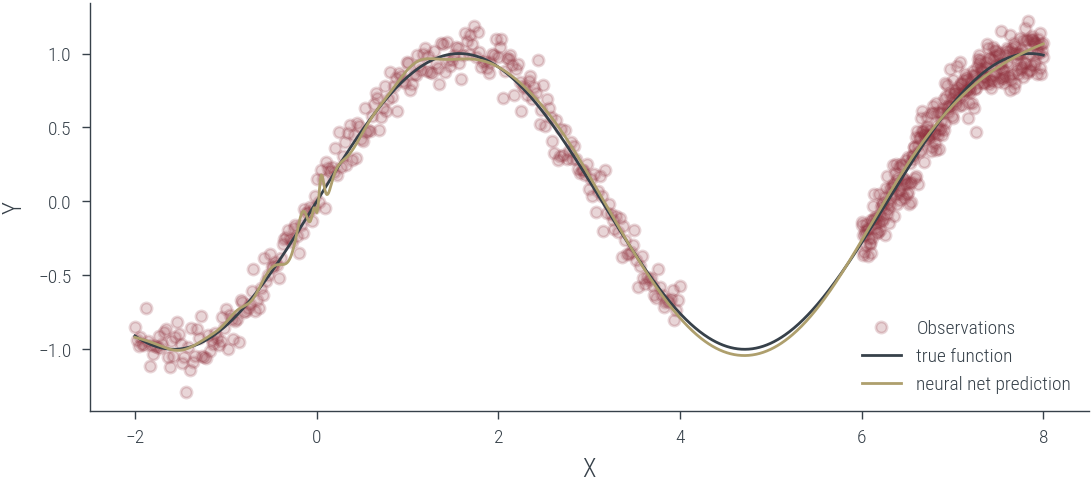

In [15]:
# Plot the trained model
with torch.no_grad():
    y_hat_trained = mlp(test_x, trained_params).ravel()
# Detach and convert to numpy
y_hat_trained = y_hat_trained.cpu().detach().numpy()

plot_predictions(test_x.cpu(), y_hat_trained)

## Deep ensemble

In [16]:
# Define a simple MLP without using nn.Linear

input_dim = 1

hidden_l1_dim = 100
hidden_l2_dim = 50


def init_params():
    W1 = nn.Parameter(torch.randn(input_dim, hidden_l1_dim, requires_grad=True).to(device))
    b1 = nn.Parameter(torch.zeros(hidden_l1_dim, requires_grad=True).to(device))
    W2 = nn.Parameter(torch.randn(hidden_l1_dim, hidden_l2_dim, requires_grad=True).to(device))
    b2 = nn.Parameter(torch.zeros(hidden_l2_dim, requires_grad=True).to(device))
    W3 = nn.Parameter(torch.randn(hidden_l2_dim, 1, requires_grad=True).to(device))
    b3 = nn.Parameter(torch.zeros(1, requires_grad=True).to(device))
    return [W1, b1, W2, b2, W3, b3]


def mlp(x, params, p=0.0):
    W1, b1, W2, b2, W3, b3 = params
    h1 = torch.tanh(x @ W1 + b1)
    h2 = torch.tanh(h1 @ W2 + b2)
    return (h2 @ W3 + b3).ravel()

In [17]:
n_ensembles = 5

ensemble_params_list = []
for i in range(n_ensembles):
    print(f"Training ensemble member {i}")
    parameters = init_params()
    optimizer = torch.optim.Adam(parameters, lr=3e-4)
    trained_params = train(parameters, optimizer, mlp, train_x, train_y, epochs=6000, dropout=False, p=0.0)
    ensemble_params_list.append(trained_params)

Training ensemble member 0
Epoch 0, loss 6.297


Epoch 300, loss 0.027
Epoch 600, loss 0.018
Epoch 900, loss 0.015
Epoch 1200, loss 0.014
Epoch 1500, loss 0.013
Epoch 1800, loss 0.012
Epoch 2100, loss 0.011
Epoch 2400, loss 0.010
Epoch 2700, loss 0.010
Epoch 3000, loss 0.010
Epoch 3300, loss 0.009
Epoch 3600, loss 0.009
Epoch 3900, loss 0.009
Epoch 4200, loss 0.009
Epoch 4500, loss 0.009
Epoch 4800, loss 0.009
Epoch 5100, loss 0.009
Epoch 5400, loss 0.009
Epoch 5700, loss 0.009
Training ensemble member 1
Epoch 0, loss 8.930
Epoch 300, loss 0.016
Epoch 600, loss 0.013
Epoch 900, loss 0.012
Epoch 1200, loss 0.011
Epoch 1500, loss 0.011
Epoch 1800, loss 0.011
Epoch 2100, loss 0.011
Epoch 2400, loss 0.010
Epoch 2700, loss 0.010
Epoch 3000, loss 0.010
Epoch 3300, loss 0.009
Epoch 3600, loss 0.009
Epoch 3900, loss 0.009
Epoch 4200, loss 0.009
Epoch 4500, loss 0.009
Epoch 4800, loss 0.009
Epoch 5100, loss 0.009
Epoch 5400, loss 0.009
Epoch 5700, loss 0.009
Training ensemble member 2
Epoch 0, loss 45.028
Epoch 300, loss 0.083
Epoch 600, loss

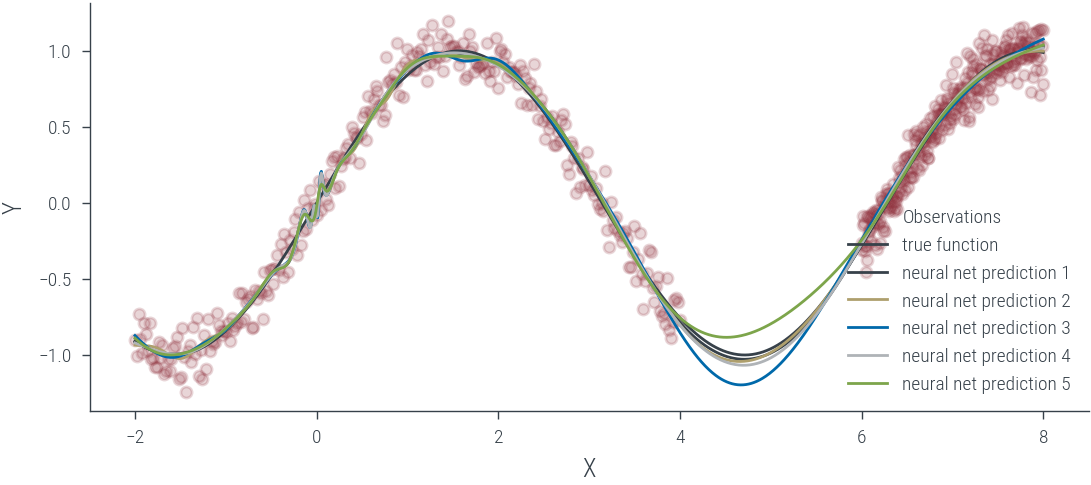

In [18]:
# Plot the trained model
def plot_deep_ensemble(x_test, y_preds_list):
    def add_predictions(ax):
        for i, y_preds in enumerate(y_preds_list, 1):
            ax.plot(x_test, y_preds, f'C{i}', label=f'neural net prediction {i}')

    plot_generic(add_predictions)

y_preds_list = []
for trained_params in ensemble_params_list:
    with torch.no_grad():
        y_hat_trained = mlp(test_x, trained_params)
        y_hat_trained = y_hat_trained.cpu().numpy()
        y_preds_list.append(y_hat_trained)
        
plot_deep_ensemble(test_x.cpu(), y_preds_list)

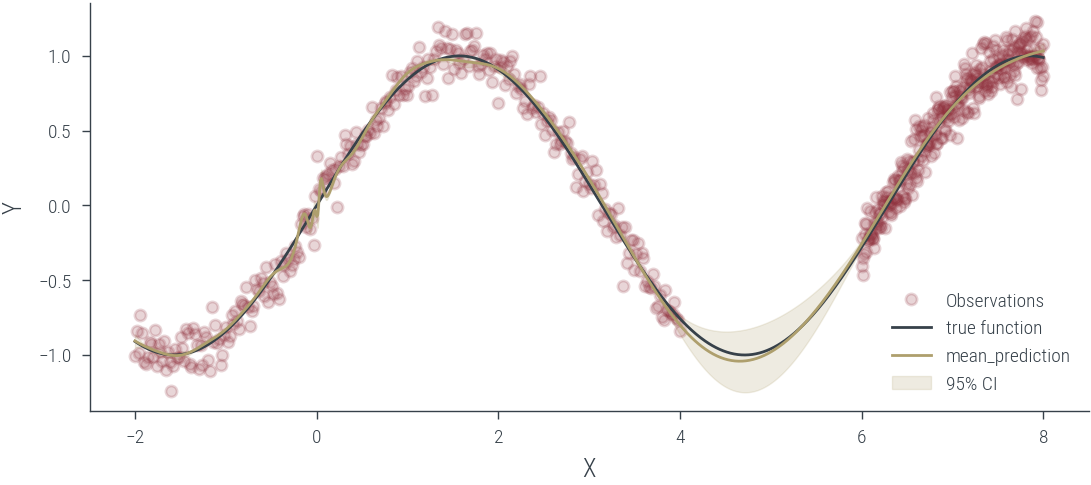

In [19]:
def plot_deep_ensemble_uncertainty(x_test, y_preds_list):
    def add_predictions(ax):
        y_mean = np.array(y_preds_list).mean(axis=0)
        y_std = np.array(y_preds_list).std(axis=0)
        ax.plot(x_test, y_mean, f'C2', label=f'mean_prediction')
        ax.fill_between(x_test.ravel(), y_mean - 2*y_std, y_mean + 2*y_std, alpha=0.2, color='C2', label='95% CI')

    plot_generic(add_predictions)
    
plot_deep_ensemble_uncertainty(test_x.cpu(), y_preds_list)

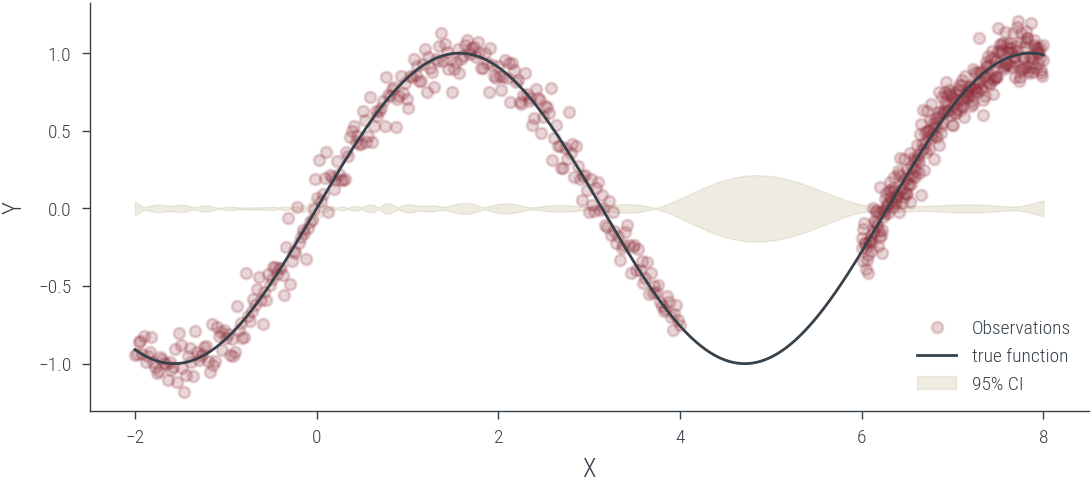

In [20]:
def plot_just_uncertainty_deep_ensemble(x_test, y_preds_list):
    def add_predictions(ax):
        y_std = np.array(y_preds_list).std(axis=0)
        ax.fill_between(x_test.ravel(), -2*y_std, 2*y_std, alpha=0.2, color='C2', label='95% CI')

    plot_generic(add_predictions)
    
plot_just_uncertainty_deep_ensemble(test_x.cpu(), y_preds_list)

## Dropout from scratch

In [21]:
### Now adding dropout to the model by manually masking the activations
W1, b1, W2, b2, W3, b3 = parameters
h1 = torch.relu(test_x @ W1 + b1)
h1.shape


torch.Size([1000, 100])

In [22]:
# probability of dropping out each neuron
p = 0.2

In [23]:
mask = torch.rand_like(h1) > p
mask.shape

torch.Size([1000, 100])

In [24]:
h1.shape

torch.Size([1000, 100])

In [25]:
mask.sum()

tensor(79869, device='cuda:0')

In [26]:
mask.numel()

100000

In [27]:
masked_activations = h1 * mask
masked_activations.shape

torch.Size([1000, 100])

In [28]:
pd.DataFrame(masked_activations.cpu().detach().numpy()).head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.0,4.610200,0.0,0.000000,0.0,0.0,5.098537,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,1.522145,0.0
1,0.0,4.586975,0.0,0.000000,0.0,0.0,5.072990,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.141135,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.000000,0.0,0.537094,0.0,0.0,5.047443,0.0,0.0,0.0,...,0.0,0.143874,0.0,0.000000,0.0,0.0,0.0,0.0,1.507122,0.0
3,0.0,4.540526,0.0,0.534456,0.0,0.0,5.021896,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,1.499610,0.0
4,0.0,4.517301,0.0,0.531817,0.0,0.0,4.996349,0.0,0.0,0.0,...,0.0,0.142412,0.0,0.138820,0.0,0.0,0.0,0.0,1.492098,0.0


In [29]:
pd.DataFrame(h1.cpu().detach().numpy()).head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.0,4.610200,0.0,0.542371,0.0,0.0,5.098537,0.0,0.0,0.0,...,0.0,0.145336,0.0,0.141907,0.0,0.0,0.0,0.0,1.522145,0.0
1,0.0,4.586975,0.0,0.539733,0.0,0.0,5.072990,0.0,0.0,0.0,...,0.0,0.144605,0.0,0.141135,0.0,0.0,0.0,0.0,1.514633,0.0
2,0.0,4.563751,0.0,0.537094,0.0,0.0,5.047443,0.0,0.0,0.0,...,0.0,0.143874,0.0,0.140363,0.0,0.0,0.0,0.0,1.507122,0.0
3,0.0,4.540526,0.0,0.534456,0.0,0.0,5.021896,0.0,0.0,0.0,...,0.0,0.143143,0.0,0.139592,0.0,0.0,0.0,0.0,1.499610,0.0
4,0.0,4.517301,0.0,0.531817,0.0,0.0,4.996349,0.0,0.0,0.0,...,0.0,0.142412,0.0,0.138820,0.0,0.0,0.0,0.0,1.492098,0.0


In [30]:
pd.DataFrame(mask.cpu().detach().numpy()).head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,False,True,True,False,True,True,True,True,False,True,...,False,False,True,False,False,True,False,True,True,True
1,False,True,True,False,True,True,True,True,True,True,...,True,False,True,True,True,True,True,True,False,True
2,True,False,False,True,True,False,True,False,False,True,...,True,True,True,False,True,False,True,False,True,False
3,True,True,True,True,True,True,True,False,True,True,...,True,False,True,False,False,True,True,False,True,False
4,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


## MC-dropout

In [31]:
### Rewriting the model with dropout

def mlp_dropout(x, params, p=0.0, training=True):
    W1, b1, W2, b2, W3, b3 = params
    h1 = torch.tanh(x @ W1 + b1)
    #h2 = torch.sin(h1 @ W2 + b2)
    #h3 = h2 @ W3 + b3
    #return h3
    if training:
        # probability of dropping out each neuron
        mask = torch.rand_like(h1) > p
        h1 = h1 * mask
        # scale activations to account for dropout
        #h1 = h1 / (1 - p)
    h2 = torch.tanh(h1 @ W2 + b2)
    if training:
        # probability of dropping out each neuron
        mask = torch.rand_like(h2) > p
        h2 = h2 * mask
        # scale activations to account for dropout
        #h2 = h2 / (1 - p)
    h3 = h2 @ W3 + b3
    return h3.ravel()

In [32]:
# Train the model
p = 0.1
parameters = init_params()

# Continue with optimizer
optimizer = torch.optim.Adam(parameters, lr=3e-4)
trained_params = train(parameters, optimizer, mlp_dropout, train_x, train_y, epochs=10000, dropout=True, p=p)

Epoch 0, loss 13.108
Epoch 300, loss 5.365


Epoch 600, loss 4.855
Epoch 900, loss 3.415
Epoch 1200, loss 3.386
Epoch 1500, loss 3.239
Epoch 1800, loss 3.042
Epoch 2100, loss 2.347
Epoch 2400, loss 2.103
Epoch 2700, loss 1.700
Epoch 3000, loss 1.781
Epoch 3300, loss 1.422
Epoch 3600, loss 1.148
Epoch 3900, loss 1.104
Epoch 4200, loss 1.019
Epoch 4500, loss 0.920
Epoch 4800, loss 0.672
Epoch 5100, loss 0.609
Epoch 5400, loss 0.531
Epoch 5700, loss 0.450
Epoch 6000, loss 0.386
Epoch 6300, loss 0.338
Epoch 6600, loss 0.303
Epoch 6900, loss 0.283
Epoch 7200, loss 0.227
Epoch 7500, loss 0.214
Epoch 7800, loss 0.170
Epoch 8100, loss 0.171
Epoch 8400, loss 0.156
Epoch 8700, loss 0.133
Epoch 9000, loss 0.122
Epoch 9300, loss 0.124
Epoch 9600, loss 0.128
Epoch 9900, loss 0.113


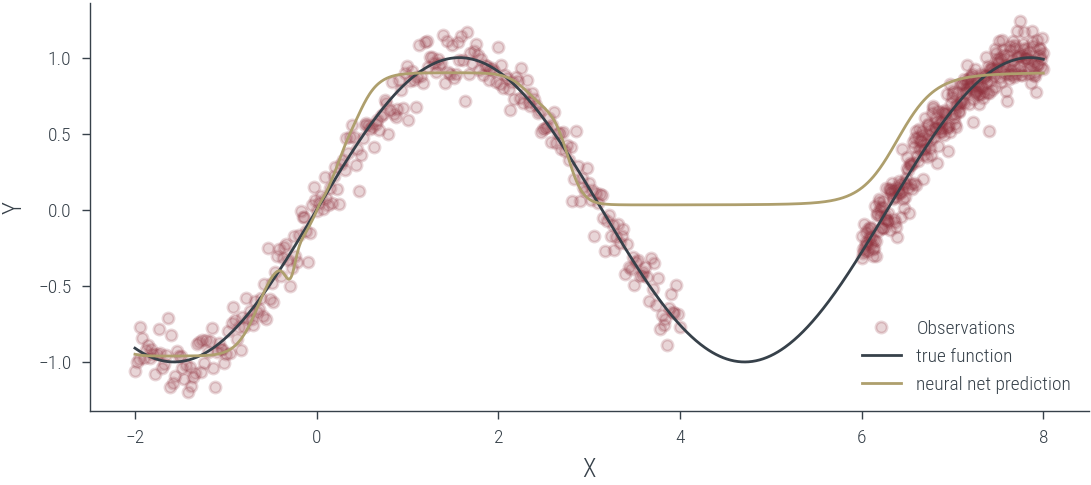

In [33]:
# Predictions with dropout
with torch.no_grad():
    y_hat_dropout = mlp_dropout(test_x, trained_params, training=False).ravel()

# Detach and convert to numpy
y_hat_dropout = y_hat_dropout.cpu().detach().numpy()

plot_predictions(test_x.cpu(), y_hat_dropout)

    

In [34]:
# Get the predictions for the test set with dropout set to True

preds = []
for i in range(100):
    with torch.no_grad():
        y_hat_dropout = mlp_dropout(test_x, trained_params, training=True, p=p).ravel()
    # Detach and convert to numpy
    y_hat_dropout = y_hat_dropout.cpu().detach().numpy()
    preds.append(y_hat_dropout)

In [35]:
# Plot MC dropout predictions

preds = np.array(preds)
preds.shape

(100, 1000)

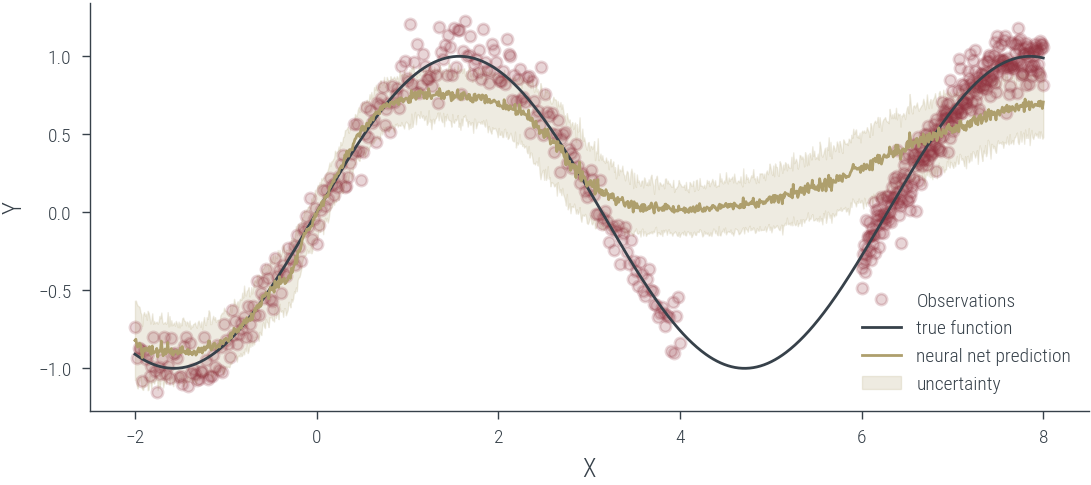

In [36]:
# Plot mean and variance of MC dropout predictions

mean = preds.mean(axis=0)
std = preds.std(axis=0)

def plot_predictions_with_uncertainty(x_test, y_preds, y_std):
    def add_predictions(ax):
        ax.plot(x_test, y_preds, 'C2', label='neural net prediction')
        ax.fill_between(x_test.ravel(), y_preds - y_std, y_preds + y_std, alpha=0.2, color='C2', label='uncertainty')

    plot_generic(add_predictions)

plot_predictions_with_uncertainty(test_x.cpu(), mean, std)


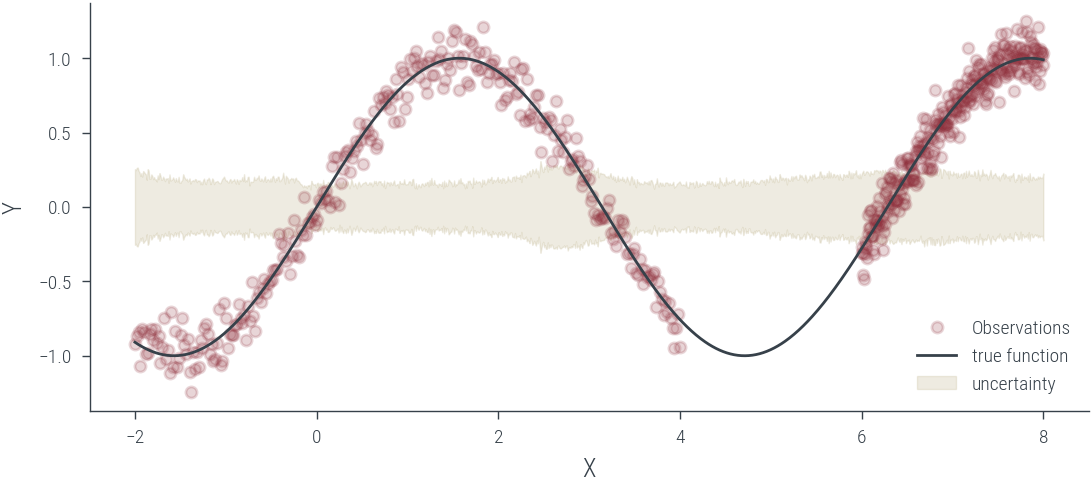

In [37]:
# Just plot the uncertainty

def plot_uncertainty(x_test, y_std):
    def add_predictions(ax):
        ax.fill_between(x_test.ravel(), -y_std, y_std, alpha=0.2, color='C2', label='uncertainty')

    plot_generic(add_predictions)
    
plot_uncertainty(test_x.cpu(), std)

## MLP with residual connections

> We need to have same number of neurons in all layers to form a residual connection.

In [38]:
# Define a simple MLP without using nn.Linear

input_dim = 1

hidden_l1_dim = 50
hidden_l2_dim = 50


def init_params():
    W1 = nn.Parameter(torch.randn(input_dim, hidden_l1_dim, requires_grad=True).to(device))
    b1 = nn.Parameter(torch.zeros(hidden_l1_dim, requires_grad=True).to(device))
    W2 = nn.Parameter(torch.randn(hidden_l1_dim, hidden_l2_dim, requires_grad=True).to(device))
    b2 = nn.Parameter(torch.zeros(hidden_l2_dim, requires_grad=True).to(device))
    W3 = nn.Parameter(torch.randn(hidden_l2_dim, 1, requires_grad=True).to(device))
    b3 = nn.Parameter(torch.zeros(1, requires_grad=True).to(device))
    return [W1, b1, W2, b2, W3, b3]


def mlp(x, params, p=0.0):
    W1, b1, W2, b2, W3, b3 = params
    h1 = torch.tanh(x @ W1 + b1)
    h2 = torch.tanh(h1 @ W2 + b2)
    # residual connection
    h2 = h2 + h1
    return (h2 @ W3 + b3).ravel()

In [39]:
parameters = init_params()

# Continue with optimizer
optimizer = torch.optim.Adam(parameters, lr=3e-4)

trained_params = train(parameters, optimizer, mlp, train_x, train_y, epochs=6000, dropout=False, p=0.0)

Epoch 0, loss 1.935
Epoch 300, loss 0.062


Epoch 600, loss 0.021
Epoch 900, loss 0.014
Epoch 1200, loss 0.013
Epoch 1500, loss 0.012
Epoch 1800, loss 0.012
Epoch 2100, loss 0.012
Epoch 2400, loss 0.012
Epoch 2700, loss 0.012
Epoch 3000, loss 0.012
Epoch 3300, loss 0.011
Epoch 3600, loss 0.011
Epoch 3900, loss 0.011
Epoch 4200, loss 0.011
Epoch 4500, loss 0.010
Epoch 4800, loss 0.010
Epoch 5100, loss 0.010
Epoch 5400, loss 0.009
Epoch 5700, loss 0.009


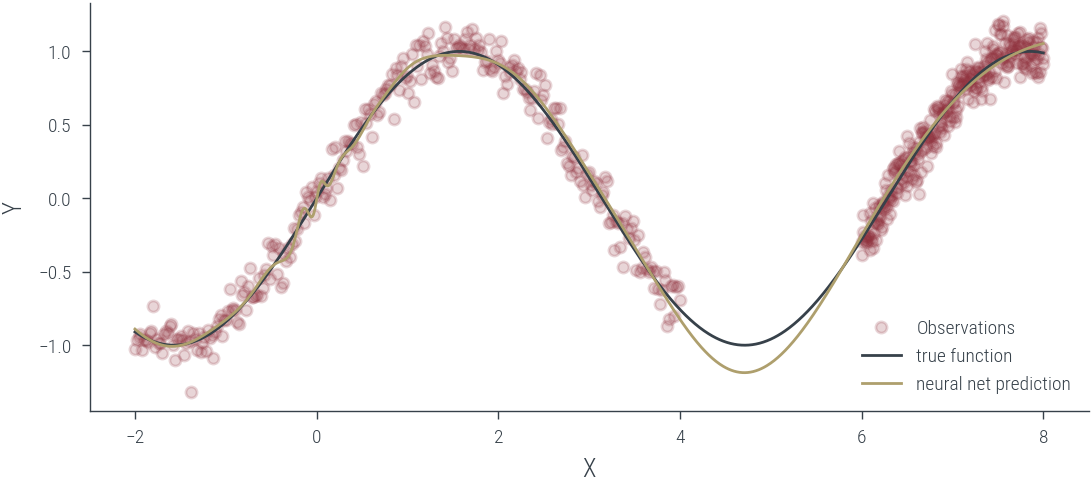

In [40]:
# Plot the trained model
with torch.no_grad():
    y_hat_trained = mlp(test_x, trained_params).ravel()
# Detach and convert to numpy
y_hat_trained = y_hat_trained.cpu().detach().numpy()

plot_predictions(test_x.cpu(), y_hat_trained)

## Deep ensemble with residual connections

In [41]:
n_ensembles = 5

ensemble_params_list = []
for i in range(n_ensembles):
    print(f"Training ensemble member {i}")
    parameters = init_params()
    optimizer = torch.optim.Adam(parameters, lr=3e-4)
    trained_params = train(parameters, optimizer, mlp, train_x, train_y, epochs=6000, dropout=False, p=0.0)
    ensemble_params_list.append(trained_params)

Training ensemble member 0
Epoch 0, loss 72.589


Epoch 300, loss 0.092
Epoch 600, loss 0.030
Epoch 900, loss 0.023
Epoch 1200, loss 0.020
Epoch 1500, loss 0.017
Epoch 1800, loss 0.015
Epoch 2100, loss 0.014
Epoch 2400, loss 0.012
Epoch 2700, loss 0.011
Epoch 3000, loss 0.010
Epoch 3300, loss 0.010
Epoch 3600, loss 0.010
Epoch 3900, loss 0.009
Epoch 4200, loss 0.009
Epoch 4500, loss 0.009
Epoch 4800, loss 0.009
Epoch 5100, loss 0.009
Epoch 5400, loss 0.009
Epoch 5700, loss 0.009
Training ensemble member 1
Epoch 0, loss 31.470
Epoch 300, loss 0.095
Epoch 600, loss 0.030
Epoch 900, loss 0.022
Epoch 1200, loss 0.018
Epoch 1500, loss 0.015
Epoch 1800, loss 0.014
Epoch 2100, loss 0.013
Epoch 2400, loss 0.012
Epoch 2700, loss 0.012
Epoch 3000, loss 0.012
Epoch 3300, loss 0.012
Epoch 3600, loss 0.011
Epoch 3900, loss 0.011
Epoch 4200, loss 0.011
Epoch 4500, loss 0.011
Epoch 4800, loss 0.011
Epoch 5100, loss 0.010
Epoch 5400, loss 0.010
Epoch 5700, loss 0.010
Training ensemble member 2
Epoch 0, loss 37.518
Epoch 300, loss 0.173
Epoch 600, los

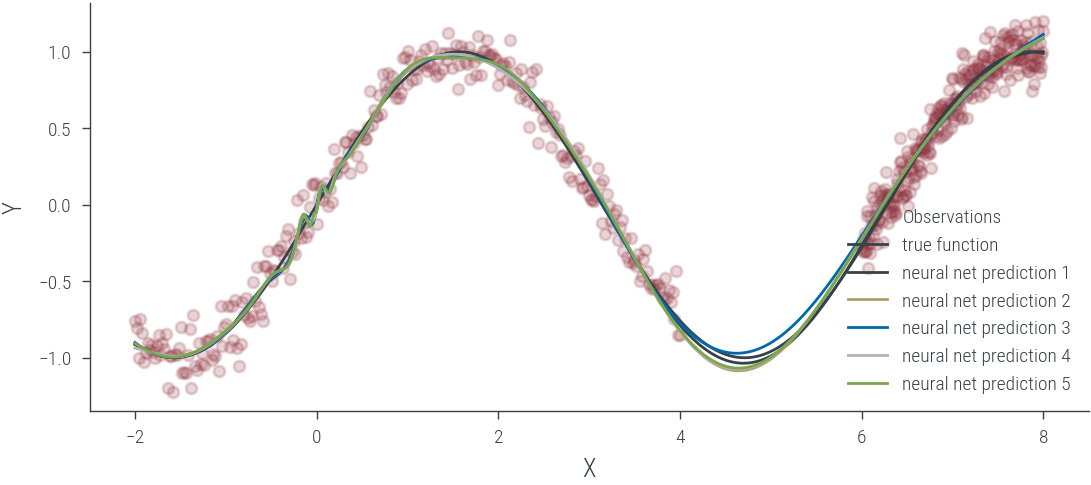

In [42]:
y_preds_list = []
for trained_params in ensemble_params_list:
    with torch.no_grad():
        y_hat_trained = mlp(test_x, trained_params)
        y_hat_trained = y_hat_trained.cpu().numpy()
        y_preds_list.append(y_hat_trained)
        
plot_deep_ensemble(test_x.cpu(), y_preds_list)

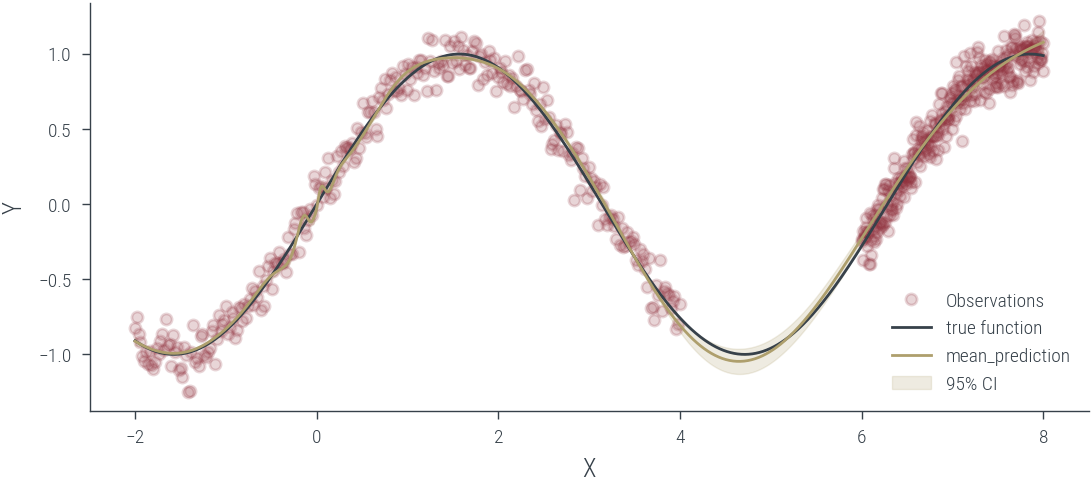

In [43]:
plot_deep_ensemble_uncertainty(test_x.cpu(), y_preds_list)

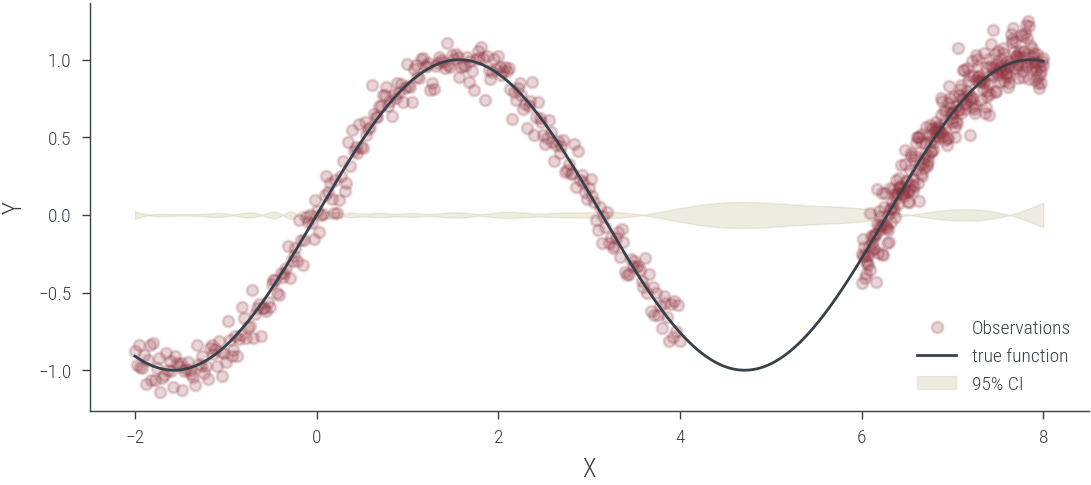

In [44]:
plot_just_uncertainty_deep_ensemble(test_x.cpu(), y_preds_list)

## MC-dropout with residual connections

In [45]:
### Rewriting the model with dropout

input_dim = 1

hidden_l1_dim = 30
hidden_l2_dim = 30

def init_params():
    W1 = nn.Parameter(torch.randn(input_dim, hidden_l1_dim, requires_grad=True).to(device))
    b1 = nn.Parameter(torch.zeros(hidden_l1_dim, requires_grad=True).to(device))
    W2 = nn.Parameter(torch.randn(hidden_l1_dim, hidden_l2_dim, requires_grad=True).to(device))
    b2 = nn.Parameter(torch.zeros(hidden_l2_dim, requires_grad=True).to(device))
    W3 = nn.Parameter(torch.randn(hidden_l2_dim, 1, requires_grad=True).to(device))
    b3 = nn.Parameter(torch.zeros(1, requires_grad=True).to(device))
    return [W1, b1, W2, b2, W3, b3]

def mlp_dropout(x, params, p=0.0, training=True):
    W1, b1, W2, b2, W3, b3 = params
    h1 = torch.tanh(x @ W1 + b1)
    #####################
    # We don't want to apply dropout to the input layer
    #####################
    # if training:
        # probability of dropping out each neuron
        # mask = torch.rand_like(h1) > p
        # h1 = h1 * mask
        # scale activations to account for dropout
        #h1 = h1 / (1 - p)
    h2 = torch.tanh(h1 @ W2 + b2)
    if training:
        # probability of dropping out each neuron
        mask = torch.rand_like(h2) > p
        h2 = h2 * mask
    # add residual connection
    h2 = h2 + h1
    h3 = h2 @ W3 + b3
    return h3.ravel()

In [46]:
# Train the model
p = 0.5
parameters = init_params()

# Continue with optimizer
optimizer = torch.optim.Adam(parameters, lr=1e-3)
trained_params = train(parameters, optimizer, mlp_dropout, train_x, train_y, epochs=6000, dropout=True, p=p)

Epoch 0, loss 33.614
Epoch 300, loss 2.223


Epoch 600, loss 0.847
Epoch 900, loss 0.312
Epoch 1200, loss 0.230
Epoch 1500, loss 0.160
Epoch 1800, loss 0.126
Epoch 2100, loss 0.097
Epoch 2400, loss 0.064
Epoch 2700, loss 0.054
Epoch 3000, loss 0.049
Epoch 3300, loss 0.044
Epoch 3600, loss 0.041
Epoch 3900, loss 0.033
Epoch 4200, loss 0.033
Epoch 4500, loss 0.035
Epoch 4800, loss 0.032
Epoch 5100, loss 0.031
Epoch 5400, loss 0.029
Epoch 5700, loss 0.028


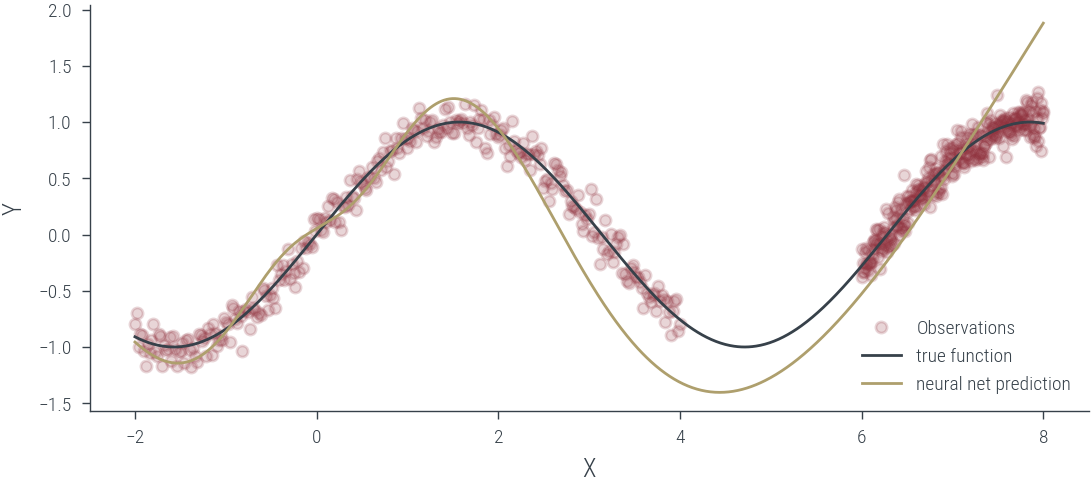

In [47]:
# Predictions with dropout
with torch.no_grad():
    y_hat_dropout = mlp_dropout(test_x, trained_params, training=False).ravel()

# Detach and convert to numpy
y_hat_dropout = y_hat_dropout.cpu().detach().numpy()

plot_predictions(test_x.cpu(), y_hat_dropout)

In [48]:
# Get the predictions for the test set with dropout set to True

preds = []
for i in range(100):
    with torch.no_grad():
        y_hat_dropout = mlp_dropout(test_x, trained_params, training=True, p=p).ravel()
    # Detach and convert to numpy
    y_hat_dropout = y_hat_dropout.cpu().detach().numpy()
    preds.append(y_hat_dropout)

preds = np.array(preds)
preds.shape

(100, 1000)

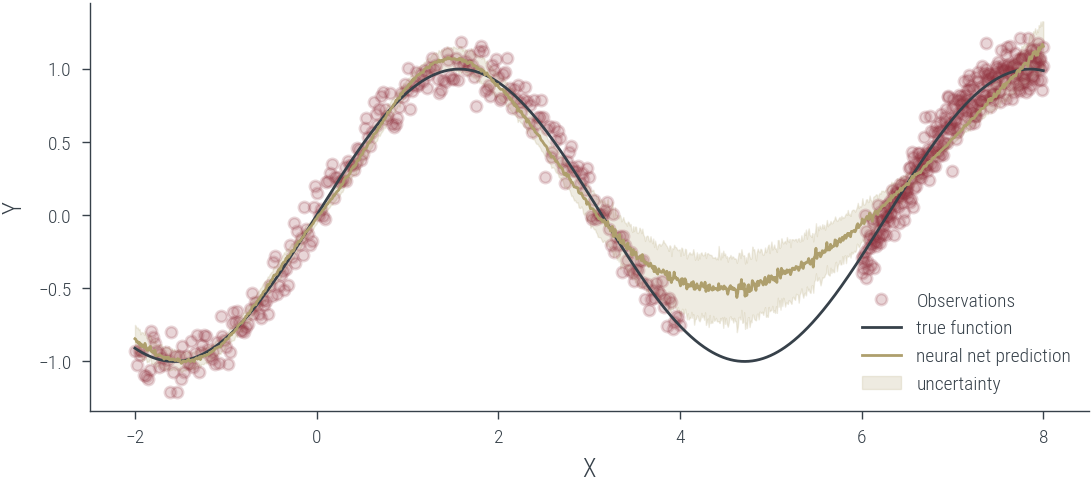

In [49]:
# Plot mean and variance of MC dropout predictions

mean = preds.mean(axis=0)
std = preds.std(axis=0)

def plot_predictions_with_uncertainty(x_test, y_preds, y_std):
    def add_predictions(ax):
        ax.plot(x_test, y_preds, 'C2', label='neural net prediction')
        ax.fill_between(x_test.ravel(), y_preds - y_std, y_preds + y_std, alpha=0.2, color='C2', label='uncertainty')

    plot_generic(add_predictions)

plot_predictions_with_uncertainty(test_x.cpu(), mean, std)

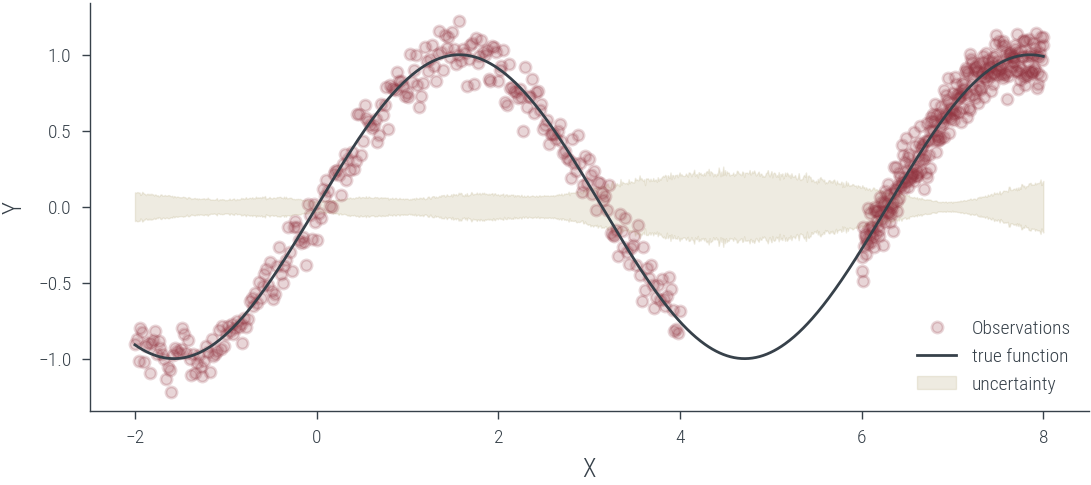

In [50]:
# Just plot the uncertainty

def plot_uncertainty(x_test, y_std):
    def add_predictions(ax):
        ax.fill_between(x_test.ravel(), -y_std, y_std, alpha=0.2, color='C2', label='uncertainty')

    plot_generic(add_predictions)
    
plot_uncertainty(test_x.cpu(), std)